# Codigo fuente
 No modificar

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd 
import sys
import math
import random
import numpy as np
from itertools import combinations
import gurobipy as gp
from gurobipy import GRB
import math
from itertools import islice
import re

class LotStreaming:
    def __init__(self,name):
        self.name = name

    def chart_color(self,numb):
        if len(self.X)<11:
            mcolores = list(mcolors.TABLEAU_COLORS.keys())
        else:
            mcolores = list(mcolors.XKCD_COLORS.keys())
        for i in range(self.L):
            if numb in self.nl[i]:
                return mcolores[i]
        
    def set_machines(self,maq):
        if maq == "A":
            return 10
        else:
            n_machine = int(maq.split(".")[-1])
            return (n_machine+1)*10
        
    def get_lote(self,sublote):
        for i in range(self.L):
            if sublote in self.nl[i]:
                return i

    def from_position_to_sublote(self,position):
        for i in self.x:
            if self.x[i].X>0 and position == i[1]:
                return int(i[0])
            
    def plot_gantt(self,name = None):
        data = self.final_data

        lista_maquinas = []
        for maquina in data["maquina"].unique():
            datos_maquina = data[data["maquina"] == maquina][["maquina","start", "duracion", "color","sublote"]].values.tolist()
            lista_maquinas.append(datos_maquina)

        fig, ax = plt.subplots(figsize=(10,5))
        yticks = [15 + 10*i for i in range(self.K+1)]
        ylim = 15+10*(self.K+1)
        ax.set_ylim(9, ylim)
        ax.set_xlabel('Tiempo')
        ax.set_ylabel('Etapa')
        if len(self.X)<11:
            mcolores = list(mcolors.TABLEAU_COLORS.keys())
        else:
            mcolores = list(mcolors.XKCD_COLORS.keys())

        for i in range(self.L):
            ax.broken_barh([(0,0)],(0,0),facecolors = mcolores[i],label = f"Lote {i+1}")
        
        ax.set_yticks(yticks)
        ax.set_yticklabels(['A']+[f'B.{i}' for i in range(1,len(yticks))])

        for i in lista_maquinas:
            chart = [(start,max(0,dur)) for maq,start,dur,color,sublote in i]
            colors = [color for maq,start,dur,color,sublote in i]
            sublotes = [sublote for maq,start,dur,color,sublote in i]
            maq = self.set_machines(i[0][0])
            ax.broken_barh(chart,(maq,9),facecolors= colors,edgecolors="black")
            for j in range(len(sublotes)):
                ax.text(chart[j][0]+chart[j][1]/2, maq+4 ,sublotes[j],horizontalalignment='center',verticalalignment='center',)
        
        cmax = max(data["end"])
        plt.legend(loc = "upper left")
        plt.title(f"Lot Streaming Problem 1/{self.K}")
        plt.text(max(data["end"])*0.9,max(yticks)+12,"Benjamin Brandt | Pablo Gutiérrez\nMII UdeC",fontsize = 6)
        plt.vlines([0,cmax], 0,[0,max(yticks)+10] , linestyle="dashed",colors="black")
        plt.text(cmax*1.01,11 ,f"Cmax = {cmax}", fontsize = 8,color = "red",bbox=dict(facecolor='white', edgecolor='red'))
        if name is not None:
            plt.savefig(f"{name}.png")
        plt.show()
        
    def set_parameters(self,**parameters):
        print(parameters)

    def create_model(self):
        self.L = len(self.X)
        n = [math.floor(self.X[i]/self.q[i]) for i in range(self.L)]
        
        l = iter([i for i in range(1,sum(n)+1)])
        self.nl = [list(islice(l, i)) for i in n]

        self.M = 10000

        self.I = np.sum(n) # Numero total de sublotes
        self.J = self.I # Nr de posiciones en la sequencia

        self.modelo = gp.Model(self.name)

        self.x = self.modelo.addVars([(i,j,k) for i in range(1,self.I+1) for j in range(1,self.J+1) for k in range(1,self.K+1)], vtype=GRB.INTEGER, name='x', lb= 0)
        y = self.modelo.addVars([(i,j,k) for i in range(1,self.I+1) for j in range(1,self.J+1) for k in range(1,self.K+1)], vtype=GRB.BINARY, name='y')
        self.STA = self.modelo.addVars([j for j in range(1,self.J+1)], vtype=GRB.CONTINUOUS, name='self.STA', lb = 0)
        self.FTA = self.modelo.addVars([j for j in range(1,self.J+1)], vtype=GRB.CONTINUOUS, name='self.FTA', lb = 0)
        self.STB = self.modelo.addVars([(j,k) for j in range(1,self.J+1) for k in range(1,self.K+1)], vtype=GRB.CONTINUOUS, name='self.STB', lb = 0)
        self.FTB = self.modelo.addVars([(j,k) for j in range(1,self.J+1) for k in range(1,self.K+1)], vtype=GRB.CONTINUOUS, name='self.FTB', lb = 0)
        Cmax = self.modelo.addVar(name="Cmax",vtype= GRB.CONTINUOUS)

        self.modelo.setObjective(Cmax, GRB.MINIMIZE)

        # 4.21
        for l in range(self.L):
            self.modelo.addConstr(gp.quicksum( self.x[(i,j,k)] for i in self.nl[l] for j in range(1,self.J+1) for k in range(1,self.K+1) ) == self.X[l] )

        # 4.22
        for l in range(self.L):
            for i in self.nl[l]:
                for j in range(1,self.J+1):
                    for k in range(1,self.K+1):
                        self.modelo.addConstr( self.x[(i,j,k)] <= self.X[l] * y[(i,j,k)])

        # 4.23
        for l in range(self.L):
            for i in self.nl[l]:
                for j in range(1,self.J+1):
                    for k in range(1,self.K+1):
                        self.modelo.addConstr( self.x[(i,j,k)] >= self.q[l] * y[(i,j,k)] ,f"min_capacity,{i},{j},{k}")

        # 4.24
        self.modelo.addConstr( self.STA[1] == 0 )

        # NEW CONSTRAINT
        for j in range(1,self.J+1):
            self.modelo.addConstr(self.FTA[j] == self.STA[j] + gp.quicksum(self.TPA[l] * self.x[(i,j,k)] + self.SA[l] * y[(i,j,k)] for l in range(self.L) for i in self.nl[l] for k in range(1,self.K+1) ) )

        # 4.25 MODIFIED CONSTRAINT
        for j in range(1,self.J+1):
            if j > 1:
                self.modelo.addConstr( self.STA[j] == self.FTA[j-1]) 

        # 4.27 MODIFIED CONSTRAINT
        for j in range(1, self.J+1): 
            for k in range(1,self.K+1):
                self.modelo.addConstr( self.STB[(j,k)] >= self.FTA[j])

        # 4.28 MODIFIED CONSTRAINT
        for j in range(1, self.J+1):
            if j > 1:
                for k in range(1,self.K+1):
                    self.modelo.addConstr( self.STB[(j,k)] >= self.STB[(j-1,k)] )

        # NEW CONSTRAINT
        for j in range(1,self.J+1):
                for k in range(1,self.K+1):
                    self.modelo.addConstr(self.FTB[j,k] == self.STB[(j,k)] + gp.quicksum( self.TPB[l] * self.x[(i,j ,k)] + self.SB[l] * y[(i,j ,k)] for l in range(self.L) for i in self.nl[l] ) )

        # 4.29 MODIFIED CONSTRAINT
        for j in range(1,self.J+1):
            if j > 1:
                for k in range(1,self.K+1):
                    self.modelo.addConstr( self.STB[(j,k)] >= self.FTB[j-1,k] )

        # 4.30 MODIFIED CONSTRAINT
        for k in range(1,self.K+1):
            self.modelo.addConstr( Cmax >= self.FTB[self.J,k] )

        # 4.31
        for j in range(1,self.J+1):
            self.modelo.addConstr( gp.quicksum( y[(i,j,k)] for i in range(1,self.I+1) for k in range(1,self.K+1) ) == 1 )

        # 4.32
        for i in range(1,self.I+1):
                self.modelo.addConstr( gp.quicksum( y[(i,j,k)] for j in range(1,self.J+1) for k in range(1,self.K+1) ) == 1 )
        
        # self.modelo.addConstr(self.x[15,1,1] == 20)
        # self.modelo.addConstr(self.x[9,2,2] == 20)
        # self.modelo.addConstr(self.x[10,3,3] == 20)
        # self.modelo.addConstr(self.x[14,4,2] == 20)
        # self.modelo.addConstr(self.x[12,5,1] == 20)
        # self.modelo.addConstr(self.x[13,6,3] == 20)
        # self.modelo.addConstr(self.x[11,7,1] == 20)
        # self.modelo.addConstr(self.x[8,8,3] == 20)
        # self.modelo.addConstr(self.x[3,9,2] == 20) # 
        # self.modelo.addConstr(self.x[16,10,1] == 20)
        # self.modelo.addConstr(self.x[4,11,3] == 20) #
        # self.modelo.addConstr(self.x[7,12,2] == 20)
        # self.modelo.addConstr(self.x[6,13,1] == 20)
        # self.modelo.addConstr(self.x[5,14,3] == 20) #
        # self.modelo.addConstr(self.x[1,15,2] == 20) #
        # self.modelo.addConstr(self.x[2,16,1] == 20) #
        
        self.modelo.setParam('TimeLimit', self.time_limit)
        self.modelo.setParam("OutputFlag",self.OutputFlag)
        self.modelo.update()

    def optimize(self):
        self.modelo.optimize()
        
        data = []
        for i in self.STA:
            sublote = self.from_position_to_sublote(int(i))
            values = {"maquina":"A",
                    "sublote":sublote,
                    "lote":int(self.get_lote(sublote)),
                    "start":int(self.STA[i].X),
                    "end":int(self.FTA[i].X)}
            data.append(values)

        for i in self.STB:
            if self.STB[i].X != self.FTB[i].X:
                sublote = self.from_position_to_sublote(int(i[0]))
                values = {"maquina":f"B.{i[1]}",
                        "sublote":sublote,
                        "lote":int(self.get_lote(sublote)),
                        "start":int(self.STB[i].X),
                        "end":int(self.FTB[i].X)}
                data.append(values)
        data = pd.DataFrame(data)
        
        data["duracion"] = data["end"]-data["start"]
        data["color"] = data["sublote"].apply(self.chart_color)
        self.final_data = data
    
    def get_metricas(self):
        print("Tiempos de espera")
        wait = []
        for i in range(1,self.I+1):
            A = self.final_data.query(f"sublote == {i} and maquina == 'A'")["end"].values[0]
            B = self.final_data.query(f"sublote == {i} and maquina != 'A'")["start"].values[0]
            wait.append(B-A)
        wait = np.array(wait)
        print("%-10s : %.2f "%("\tPromedio",wait.mean()))
        print("%-10s : %.0f "%("\tTotal",wait.sum()))
        print("%-10s : %.0f "%("\tMáximo",wait.max()))
        print()
        print("Utilización por máquina:")
        utilizacion = self.final_data.groupby("maquina").agg({"duracion":"sum"}).reset_index()
        cmax = self.final_data["end"].max()
        utilizacion["duracion"] = utilizacion["duracion"]/cmax
        for ind in utilizacion.index:
            maq = utilizacion['maquina'][ind]
            ut = utilizacion['duracion'][ind]
            print("\t %-5s : %.3f"%(maq,ut))


    

# Modelo base
Parámetros dados en clases
$$
\begin{align*}
&X &= &[100,160,60]\\
&q &= &[20,20,20]\\
&TPA &= &[15,10,12]\\
&TPB &= &[45,35,50]\\
&SA &= &[40,30,20]\\
&SB &= &[45,35,40]\\
&K &= &3
\end{align*}
$$

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-24
Set parameter TimeLimit to value 5


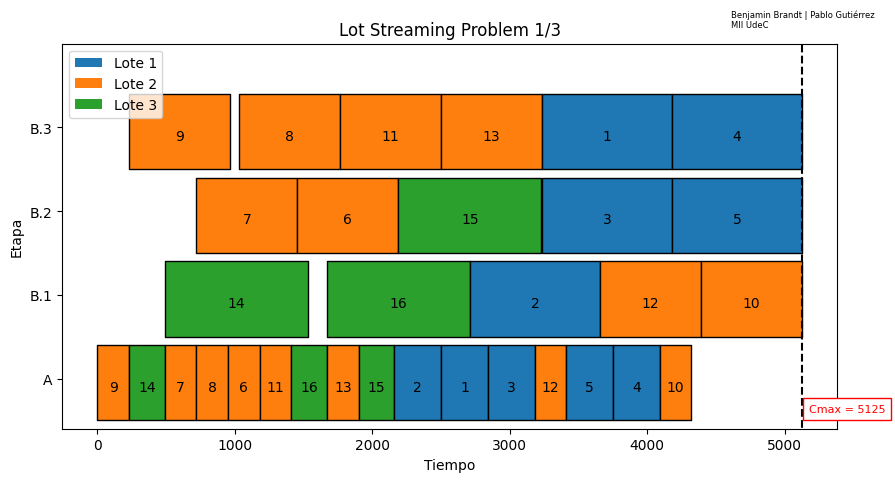

Tiempos de espera
	Promedio  : 177.19 
	Total     : 2835 
	Máximo    : 600 

Utilización por máquina:
	 A     : 0.843
	 B.1   : 0.877
	 B.2   : 0.859
	 B.3   : 0.942


5.000868082046509

In [ ]:
problem_b = None
problem_b = LotStreaming("Toy Problem")

#Definir parámetros
problem_b.X = [100,160,60]
problem_b.q = [20,20,20]
problem_b.TPA = [15,10,12]
problem_b.TPB = [45,35,50]
problem_b.SA = [40,30,20]
problem_b.SB = [45,35,40]
problem_b.K = 3
problem_b.time_limit = 600#float("inf")
problem_b.OutputFlag = 0 #0 to hide gurobi information

#Ejecutar modelo
problem_b.create_model()
problem_b.optimize()

#Plotear solución
problem_b.plot_gantt()
problem_b.get_metricas()
problem_b.modelo.RunTime

# Escenario 1
Tamaño minimo de lote aumenta en 10 unidades
$$
\begin{align*}
&X &= &[100,160,60]\\
&q &= &[30,30,30]\\
&TPA &= &[15,10,12]\\
&TPB &= &[45,35,50]\\
&SA &= &[40,30,20]\\
&SB &= &[45,35,40]\\
&K &= &3
\end{align*}
$$

Set parameter TimeLimit to value 1e+100


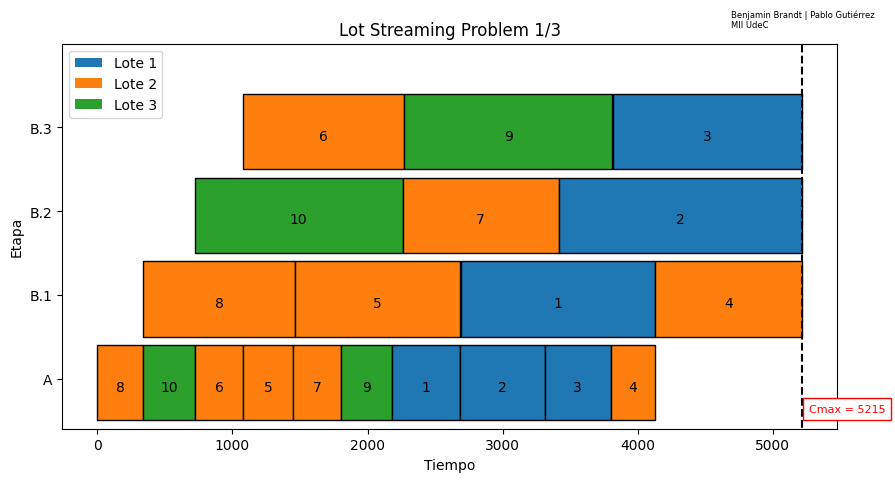

Tiempos de espera
	Promedio  : 69.00 
	Total     : 690 
	Máximo    : 460 

Utilización por máquina:
	 A     : 0.792
	 B.1   : 0.934
	 B.2   : 0.862
	 B.3   : 0.791


3.2937800884246826

In [ ]:
problem_1 = None
problem_1 = LotStreaming("Toy Problem")

#Definir parámetros
problem_1.X = [100,160,60]
problem_1.q = [30,30,30]
problem_1.TPA = [15,10,12]
problem_1.TPB = [45,35,50]
problem_1.SA = [40,30,20]
problem_1.SB = [45,35,40]
problem_1.K = 3
problem_1.time_limit = 600#float("inf")
problem_1.OutputFlag = 0 #0 to hide gurobi information

#Ejecutar modelo
problem_1.create_model()
problem_1.optimize()

#Plotear solución
problem_1.plot_gantt()
problem_1.get_metricas()
problem_1.modelo.RunTime

# Escenario 2
Tamaño minimo de lote disminuye en 10 unidades
$$
\begin{align*}
&X &= &[100,160,60]\\
&q &= &[10,10,10]\\
&TPA &= &[15,10,12]\\
&TPB &= &[45,35,50]\\
&SA &= &[40,30,20]\\
&SB &= &[45,35,40]\\
&K &= &3
\end{align*}
$$

Set parameter TimeLimit to value 1e+100


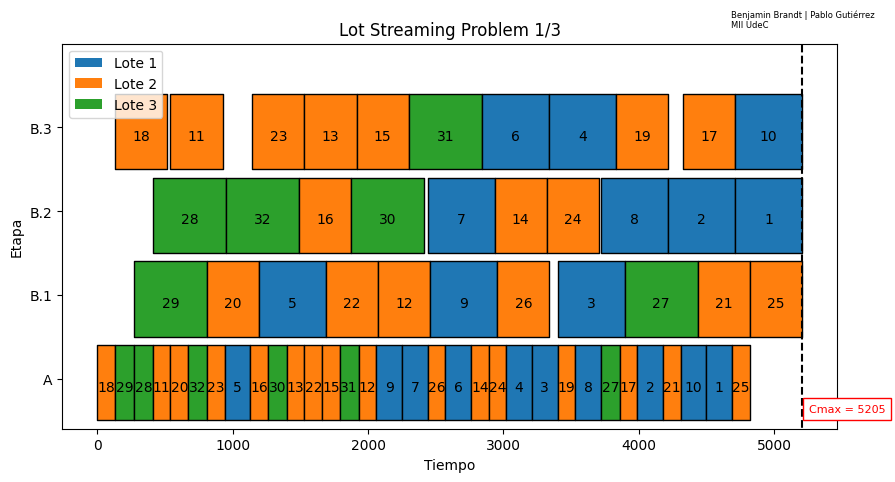

Tiempos de espera
	Promedio  : 125.00 
	Total     : 4000 
	Máximo    : 475 

Utilización por máquina:
	 A     : 0.926
	 B.1   : 0.937
	 B.2   : 0.914
	 B.3   : 0.907


4.530872821807861

In [ ]:
problem_2 = None
problem_2 = LotStreaming("Toy Problem")

#Definir parámetros
problem_2.X = [100,160,60]
problem_2.q = [10,10,10]
problem_2.TPA = [15,10,12]
problem_2.TPB = [45,35,50]
problem_2.SA = [40,30,20]
problem_2.SB = [45,35,40]
problem_2.K = 3
problem_2.time_limit = 600#float("inf")
problem_2.OutputFlag = 0 #0 to hide gurobi information

#Ejecutar modelo
problem_2.create_model()
problem_2.optimize()

#Plotear solución
problem_2.plot_gantt()
problem_2.get_metricas()
problem_2.modelo.RunTime

# Escenario 3
Número de máquinas en la etapa B aumenta en 1 unidad
$$
\begin{align*}
&X &= &[100,160,60]\\
&q &= &[20,20,20]\\
&TPA &= &[15,10,12]\\
&TPB &= &[45,35,50]\\
&SA &= &[40,30,20]\\
&SB &= &[45,35,40]\\
&K &= &4
\end{align*}
$$

Set parameter TimeLimit to value 1e+100


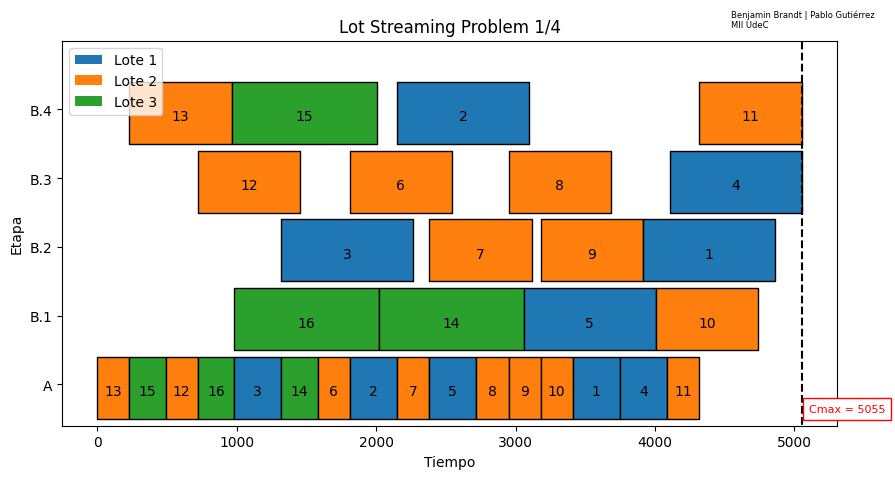

Tiempos de espera
	Promedio  : 127.19 
	Total     : 2035 
	Máximo    : 595 

Utilización por máquina:
	 A     : 0.855
	 B.1   : 0.744
	 B.2   : 0.665
	 B.3   : 0.623
	 B.4   : 0.683


0.4814889430999756

In [ ]:
problem_3 = None
problem_3 = LotStreaming("Toy Problem")

#Definir parámetros
problem_3.X = [100,160,60]
problem_3.q = [20,20,20]
problem_3.TPA = [15,10,12]
problem_3.TPB = [45,35,50]
problem_3.SA = [40,30,20]
problem_3.SB = [45,35,40]
problem_3.K = 4
problem_3.time_limit = 600#float("inf")
problem_3.OutputFlag = 0 #0 to hide gurobi information

#Ejecutar modelo
problem_3.create_model()
problem_3.optimize()

#Plotear solución
problem_3.plot_gantt()
problem_3.get_metricas()
problem_3.modelo.RunTime

# Escenario 4
Número de máquinas en la etapa B disminuye en 1 unidad
$$
\begin{align*}
&X &= &[100,160,60]\\
&q &= &[20,20,20]\\
&TPA &= &[15,10,12]\\
&TPB &= &[45,35,50]\\
&SA &= &[40,30,20]\\
&SB &= &[45,35,40]\\
&K &= &2
\end{align*}
$$

Set parameter TimeLimit to value 1e+100


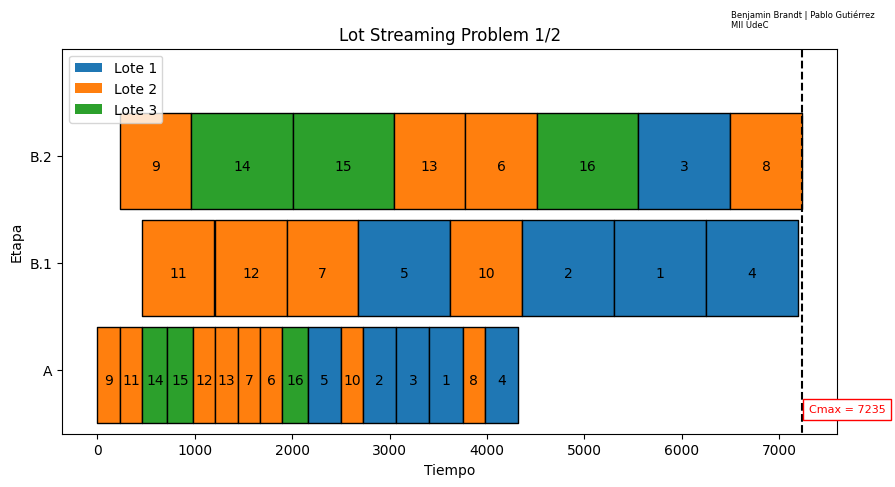

Tiempos de espera
	Promedio  : 1118.75 
	Total     : 17900 
	Máximo    : 2520 

Utilización por máquina:
	 A     : 0.597
	 B.1   : 0.929
	 B.2   : 0.968


136.09785294532776

In [ ]:
problem_4 = None
problem_4 = LotStreaming("Toy Problem")

#Definir parámetros
problem_4.X = [100,160,60]
problem_4.q = [20,20,20]
problem_4.TPA = [15,10,12]
problem_4.TPB = [45,35,50]
problem_4.SA = [40,30,20]
problem_4.SB = [45,35,40]
problem_4.K = 2
problem_4.time_limit = 600#float("inf")
problem_4.OutputFlag = 0 #0 to hide gurobi information

#Ejecutar modelo
problem_4.create_model()
problem_4.optimize()

#Plotear solución
problem_4.plot_gantt()
problem_4.get_metricas()
problem_4.modelo.RunTime

# Escenario 5
Se disminuye en un 10% los tiempos de procesamiento en la etapa B
$$
\begin{align*}
&X &= &[100,160,60]\\
&q &= &[20,20,20]\\
&TPA &= &[15,10,12]\\
&TPB &= &[40,32,45]\\
&SA &= &[40,30,20]\\
&SB &= &[45,35,40]\\
&K &= &3
\end{align*}
$$

Set parameter TimeLimit to value 1e+100


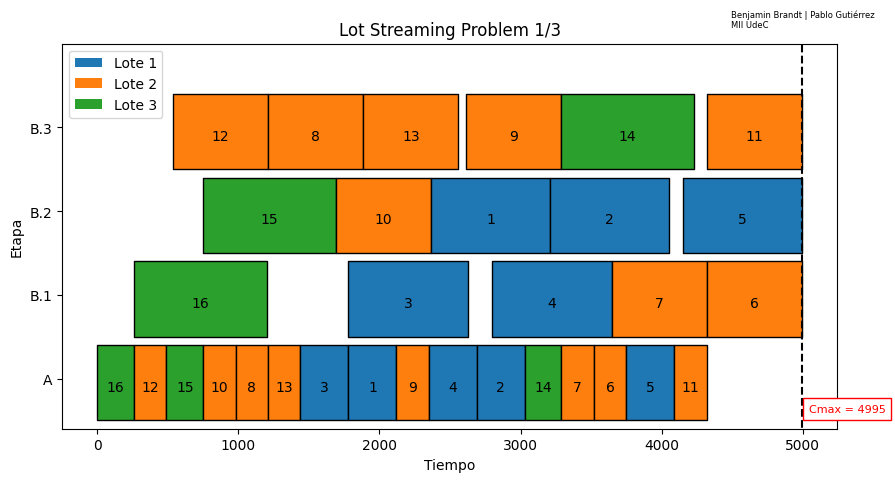

Tiempos de espera
	Promedio  : 172.19 
	Total     : 2755 
	Máximo    : 710 

Utilización por máquina:
	 A     : 0.865
	 B.1   : 0.797
	 B.2   : 0.831
	 B.3   : 0.864


2.16764497756958

In [ ]:
problem_5 = None
problem_5 = LotStreaming("Toy Problem")

#Definir parámetros
problem_5.X = [100,160,60]
problem_5.q = [20,20,20]
problem_5.TPA = [15,10,12]
problem_5.TPB = [40,32,45]
problem_5.SA = [40,30,20]
problem_5.SB = [45,35,40]
problem_5.K = 3
problem_5.time_limit = 600#float("inf")
problem_5.OutputFlag = 0 #0 to hide gurobi information

#Ejecutar modelo
problem_5.create_model()
problem_5.optimize()

#Plotear solución
problem_5.plot_gantt()
problem_5.get_metricas()
problem_5.modelo.RunTime

# Escenario 6
Se disminuye en un 10% los tiempos de procesamiento en la etapa A
$$
\begin{align*}
&X &= &[100,160,60]\\
&q &= &[20,20,20]\\
&TPA &= &[12,8,10]\\
&TPB &= &[45,35,50]\\
&SA &= &[40,30,20]\\
&SB &= &[45,35,40]\\
&K &= &3
\end{align*}
$$

Set parameter TimeLimit to value 1e+100

Interrupt request received


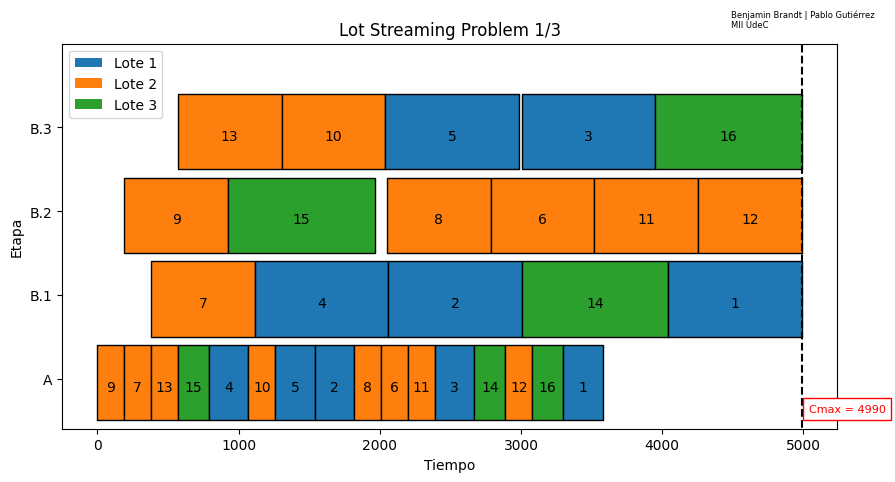

Tiempos de espera
	Promedio  : 341.25 
	Total     : 5460 
	Máximo    : 1175 

Utilización por máquina:
	 A     : 0.717
	 B.1   : 0.924
	 B.2   : 0.945
	 B.3   : 0.882


994.2154579162598

In [ ]:
problem_6 = None
problem_6 = LotStreaming("Toy Problem")

#Definir parámetros
problem_6.X = [100,160,60]
problem_6.q = [20,20,20]
problem_6.TPA = [12,8,10]
problem_6.TPB = [45,35,50]
problem_6.SA = [40,30,20]
problem_6.SB = [45,35,40]
problem_6.K = 3
problem_6.time_limit = 600#float("inf")
problem_6.OutputFlag = 0 #0 to hide gurobi information

#Ejecutar modelo
problem_6.create_model()
problem_6.optimize()

#Plotear solución
problem_6.plot_gantt()
problem_6.get_metricas()
problem_6.modelo.RunTime

# Big instance
Instancia grande para probar rendimiento en un caso aplicado
$$
\begin{align*}
&X &= &[100,160,60]\\
&q &= &[20,20,20]\\
&TPA &= &[12,8,10]\\
&TPB &= &[45,35,50]\\
&SA &= &[40,30,20]\\
&SB &= &[45,35,40]\\
&K &= &3
\end{align*}
$$

X:  [94, 76, 125, 90, 186, 175, 180, 157, 113, 84]
q:  [45, 30, 42, 43, 49, 30, 44, 38, 37, 48]
TPA:  [13, 20, 10, 10, 10, 10, 22, 16, 23, 10]
TPB:  [32, 39, 40, 32, 36, 32, 32, 39, 34, 25]
SA:  [33, 37, 40, 23, 25, 40, 29, 23, 30, 36]
SB:  [46, 48, 50, 43, 44, 44, 49, 47, 48, 46]
K:  3
Set parameter TimeLimit to value 1e+100


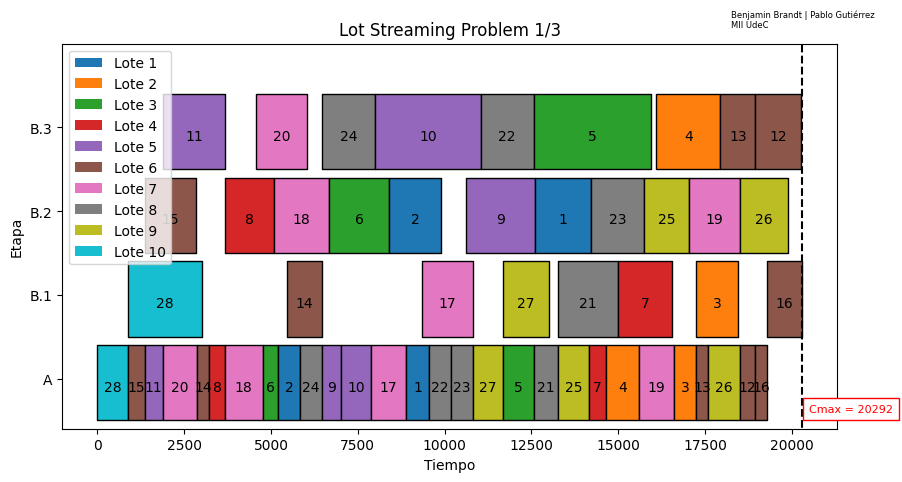

Tiempos de espera
	Promedio  : 822.86 
	Total     : 23040 
	Máximo    : 3584 

Utilización por máquina:
	 A     : 0.951
	 B.1   : 0.562
	 B.2   : 0.836
	 B.3   : 0.833


1.7065300941467285

In [ ]:
random.seed(1)
problem_7 = None
problem_7 = LotStreaming("Toy Problem")

#Definir parámetros
n_lotes = 10

problem_7.X = [random.randint(60,200) for i in range(n_lotes)]
problem_7.q = [random.randint(30,50) for i in range(n_lotes)]
problem_7.TPA = [random.randint(10,25) for i in range(n_lotes)]
problem_7.TPB = [random.randint(25,40) for i in range(n_lotes)]
problem_7.SA = [random.randint(20,40) for i in range(n_lotes)]
problem_7.SB = [random.randint(40,50) for i in range(n_lotes)]
problem_7.K = 3
problem_7.time_limit = 600#float("inf")
problem_7.OutputFlag = 0 #0 to hide gurobi information
print("X: ",problem_7.X)
print("q: ",problem_7.q)
print("TPA: ",problem_7.TPA)
print("TPB: ",problem_7.TPB)
print("SA: ",problem_7.SA)
print("SB: ",problem_7.SB)
print("K: ",problem_7.K)
#Ejecutar modelo
problem_7.create_model()
problem_7.optimize()

#Plotear solución
problem_7.plot_gantt()
problem_7.get_metricas()
problem_7.modelo.RunTime


# Aumento marginal en tiempo de proceso

In [ ]:
output = []
for i in range(0,1):
    problem_b = None
    problem_b = LotStreaming("Toy Problem")

    #Definir parámetros
    problem_b.X = [100,160,60]
    problem_b.q = [20,20,20]
    problem_b.TPA = [15,10,12]
    problem_b.TPB = [45,35,50]
    problem_b.SA = [40,30,20]
    problem_b.SB = [45,35,40]
    problem_b.K = 3
    problem_b.time_limit = 600#float("inf")
    problem_b.OutputFlag = 0 #0 to hide gurobi information

    problem_b.TPA = [j*(1-i/100) for j in problem_b.TPA]

    problem_b.create_model()
    problem_b.optimize()
    output.append((i/100,problem_b.modelo.ObjVal))
    print(i/100,problem_b.modelo.ObjVal)
for i in output:
    print(i)

Set parameter TimeLimit to value 600

Interrupt request received
0.0 5070.0
(0.0, 5070.0)


# Toy problem 1/3
## Parameters
$$
\begin{align*}
&X_l &: &\text{ Cantidad de piezas del lote } l\\
&q &: &\text{ Tamaño minimo del lote }l\\
&TPA_l &: &\text { Tiempo de producción unitario en la etapa A para un producto del lote }l \\
&TPB_l &: &\text { Tiempo de producción unitario en la etapa B para un producto del lote }l \\
&SA_l &: &\text { Tiempo de preparación del sub lote en la etapa A para un producto del lote }l \\
&SB_l &: &\text { Tiempo de preparación del sub lote en la etapa B para un producto del lote }l \\
&L&:&\text{ Número de lotes}\\
&n_l = \lfloor Q_l/q_l \rfloor&:&\text{ Número máximo de sublotes del lote }l\\
&I&:&\text{ Número total de sublotes }\\
&J = I&:&\text{ Número de posición en la secuencia}\\
&K&:&\text{ Número de módulos en la etapa B}\\
\end{align*}
$$